In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import geopandas as gpd
import os
from pathlib import Path
from dataclasses import asdict

from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor

from SSTImportanceSampling.utils import summarize_depths_by_return_period
from SSTImportanceSampling.utils import metrics
from SSTImportanceSampling.utils import plot_return_period_summary, plot_two_return_period_summaries
from SSTImportanceSampling.utils import plot_adaptive_evolution

from consequences.consequence_adaptive import AdaptParamsConsequence, AdaptiveMixtureConsequenceSampler,ConsequenceAdaptManager

In [3]:
def write_consequences(folder_path):
    output_folder = os.path.join(folder_path, "outputs")

    shapefiles = [f for f in os.listdir(output_folder) if f.endswith(".shp")]

    gdfs = []
    for shp in shapefiles:
        full_path = os.path.join(output_folder, shp)
        gdf = gpd.read_file(full_path)
        gdf["sample_id"] = os.path.splitext(shp)[0]
        gdfs.append(gdf)

    combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

    summary = combined_gdf.groupby("sample_id")[["structure", "content da"]].sum().reset_index()
    summary["consequence"] = (summary["structure"] + summary["content da"]) / 1_000_000
    summary = summary[["sample_id", "consequence"]]

    summary["sample_id"] = summary["sample_id"].str.replace(r"_result.*", "", regex=True)

    samples = pd.read_csv(os.path.join(folder_path, "to_hms.csv"))
    merged = samples.merge(summary, how="left", on="sample_id")
    merged["consequence"] = merged["consequence"].fillna(0)

    merged = merged[["sample_id", "consequence"]]
    merged.to_csv(os.path.join(folder_path, "consequences.csv"), index=False)


In [4]:
watershed_names = ["Trinity","Kanawha","Duwamish","Denton"]

In [5]:
#Load data
watersheds = {}

for wname in watershed_names:
    ws = Preprocessor.load(
        config_path=f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{wname}/config.json"
    )
    watersheds[wname] = ws

In [6]:
#Full Monte Carlo summary
base_dir = "/workspaces/Importance-Sampling-for-SST/data/2_production"
summary_filename = "fullmonte_summary.pq"

# --- load summaries ---
summaries = {}
for w in watershed_names:
    path = os.path.join(base_dir, w, summary_filename)
    df = pd.read_parquet(path)
    needed = {"RP","median_in","ci95_low_in","ci95_high_in"}
    if not needed <= set(df.columns):
        raise ValueError(f"{w}: summary missing columns {needed - set(df.columns)}")
    summaries[w] = df.sort_values("RP")

In [7]:
watershed = watersheds["Denton"]
run_dir = "/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton_consequence_run"

In [8]:
params = AdaptParamsConsequence(
    mu_x_n=watershed.watershed_stats["x"],
    mu_y_n=watershed.watershed_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"],
    sd_y_n=watershed.watershed_stats["range_y"],

    mu_x_w=watershed.domain_stats["x"],
    mu_y_w=watershed.domain_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"]/np.sqrt(12),
    sd_y_w=watershed.domain_stats["range_y"]/np.sqrt(12),

    rho_n=0.0,      # narrow corr
    rho_w=0.0,      # wide corr
    mix=0.8,        # initial narrow weight

    # Optional tuning:
    lambda_mix=0.30,
    alpha=0.75,
    K_temper=1.0,
)

sampler = AdaptiveMixtureConsequenceSampler(
    data=watershed,
    params=params,
    precip_cube=watershed.cumulative_precip,
    seed=42
)

mgr = ConsequenceAdaptManager(
    sampler=sampler,
    run_dir=run_dir,
    run_name="Denton_conseq_adapt",
    watershed_name="Denton"
)

In [9]:
asdict(mgr.current_params())

{'mu_x_n': np.float64(-133671.6174086828),
 'mu_y_n': np.float64(1132085.47964247),
 'sd_x_n': np.float64(72093.73310628998),
 'sd_y_n': np.float64(82380.71418126137),
 'rho_n': 0.0,
 'mu_x_w': np.float64(445653.92777179385),
 'mu_y_w': np.float64(1016893.361783335),
 'sd_x_w': np.float64(484215.3347282245),
 'sd_y_w': np.float64(297108.36850340647),
 'rho_w': 0.0,
 'mix': 0.8,
 'lambda_mix': 0.3,
 'beta_floor': 0.05,
 'beta_ceil': 0.95,
 'alpha': 0.75,
 'eps_var': 1e-06,
 'K_temper': 1.0,
 'beta_use_depth': True,
 'eps_floor': 1e-300}

Stop and check iter_idx

In [10]:
iter_idx = 10               # bump this manually for the next iteration (2, 3, ...)
samples_per_iter = 100
seed_for_iter = 123

In [16]:
req_paths = mgr.sample_and_write_request(
    iter_idx=iter_idx,
    samples_per_iter=samples_per_iter,
    seed=seed_for_iter
)
req_paths

{'request_parquet': PosixPath('/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton_consequence_run/iter_010/request_samples.parquet'),
 'to_hms_csv': PosixPath('/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton_consequence_run/iter_010/to_hms.csv'),
 'count': 100}

Add consequence

In [ ]:
#sample_id, consequence  f"{run_dir}/iter_{iter_idx:03d}/to_hms.csv"

In [11]:
#write consequences
folder_path = f"{run_dir}/iter_{iter_idx:03d}"
write_consequences(folder_path)

In [12]:
consequence_csv_path = f"{run_dir}/iter_{iter_idx:03d}/consequences.csv"  # put your results there
result_paths = mgr.adapt_once_with_consequences(
    iter_idx=iter_idx,
    consequences_csv_path=consequence_csv_path,
    reward_col="consequence",
    threshold=0.0
)
result_paths

{'merged_parquet': PosixPath('/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton_consequence_run/iter_010/merged.parquet'),
 'params_after': PosixPath('/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton_consequence_run/iter_010/params_after.json'),
 'history_csv': PosixPath('/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton_consequence_run/history.csv')}

In [15]:
history = pd.read_csv(Path(run_dir) / "history.csv")

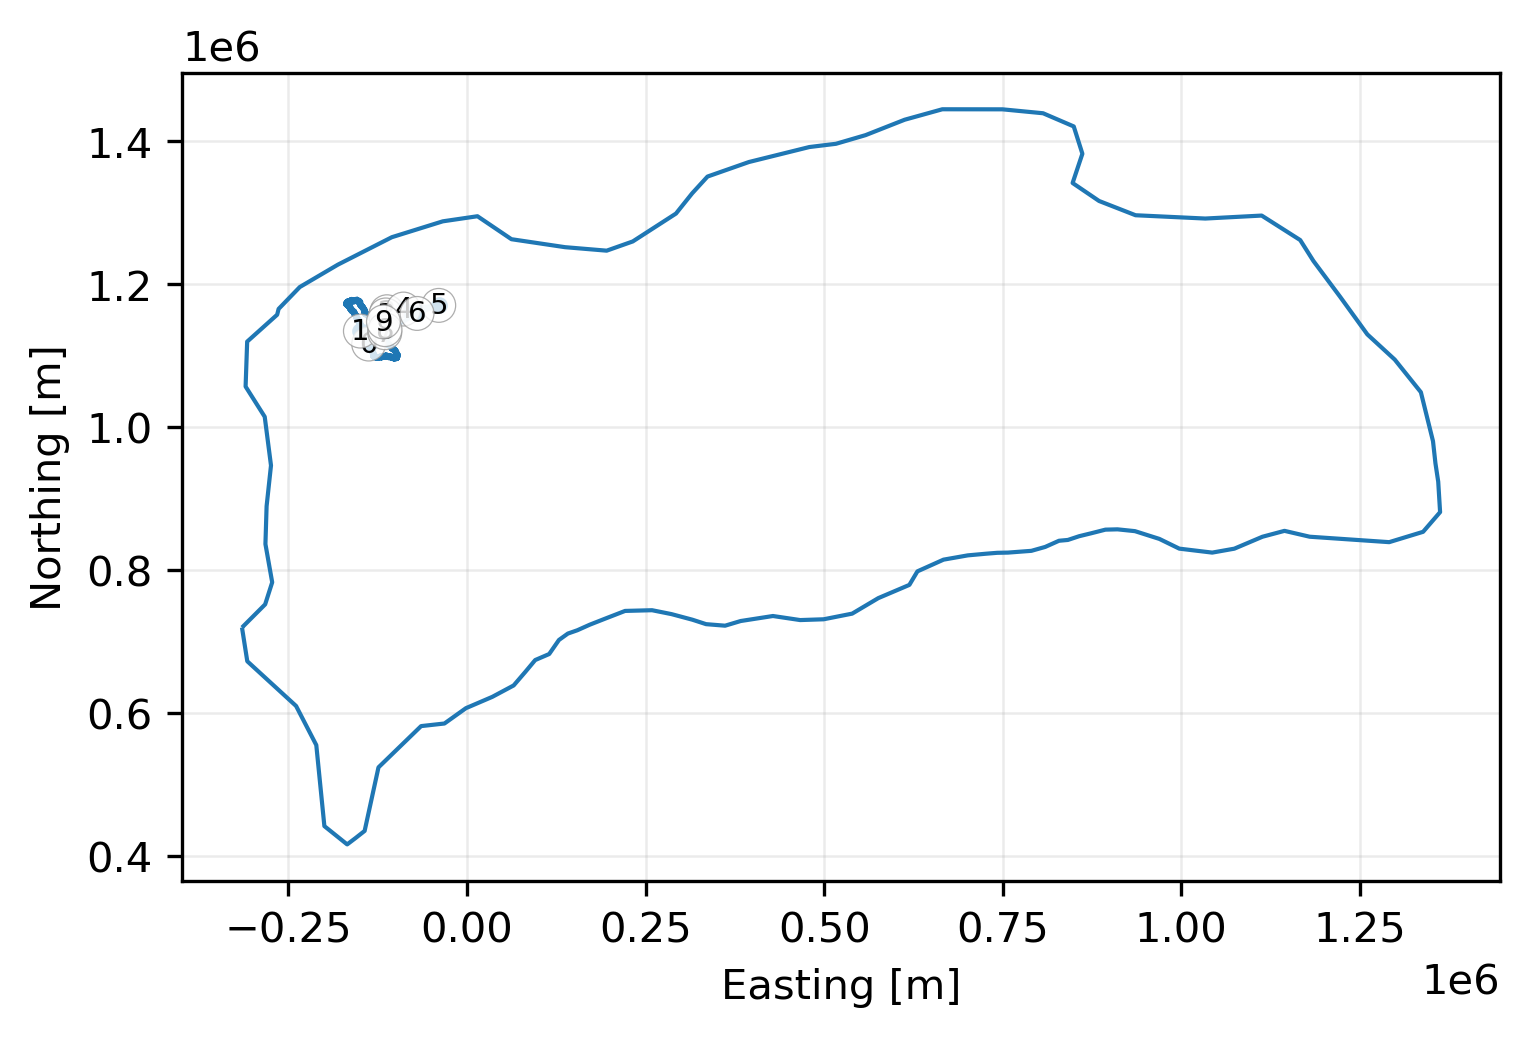

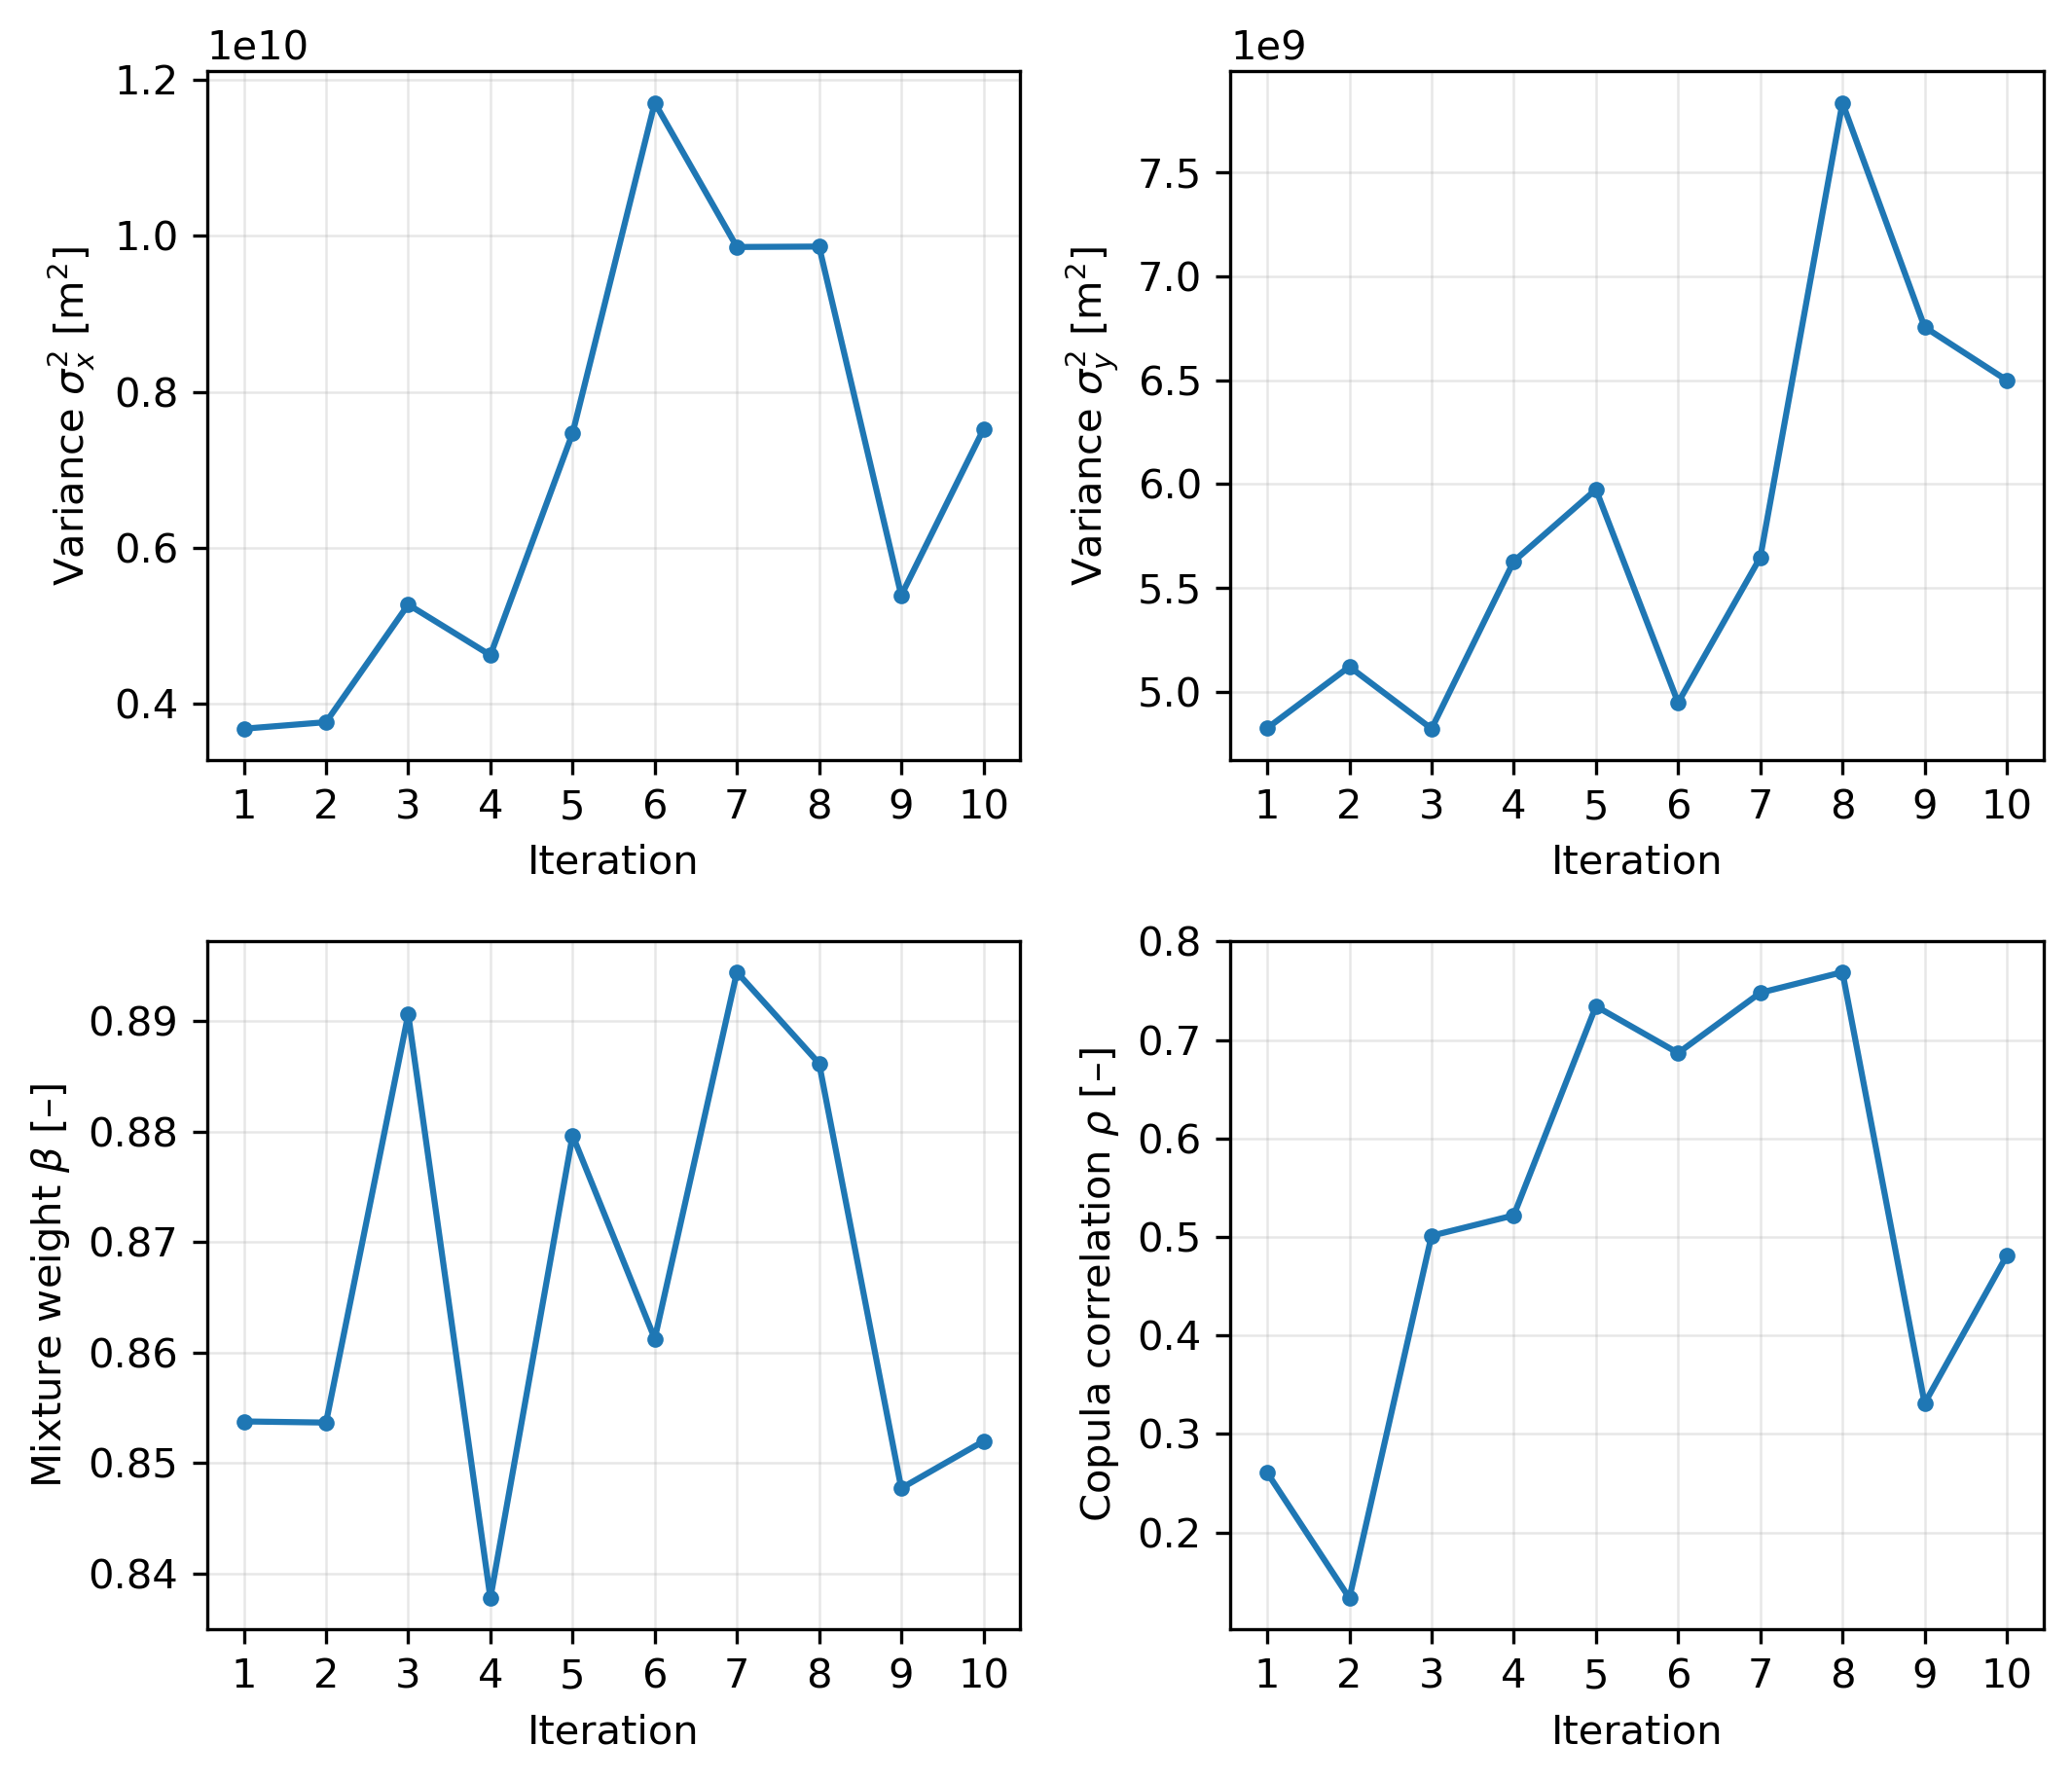

In [17]:
plot_adaptive_evolution(history, watershed.watershed_gdf, watershed.domain_gdf, save=False, prefix="trinity_ais")

In [ ]:
from production.consequence_adaptive import to_parquet  # convenience wrapper

final_df = sampler.sample_batch(n=5000, iter_idx=999, seed=777)
to_parquet(final_df, Path(run_dir) / "final_draws.parquet")
final_df.head()

In [ ]:
# Mean consequences
run_dir
folder_path = f"{run_dir}/iter_{iter_idx:03d}"


'/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton_consequence_run'